In [ ]:

!pip install --quiet scikit-learn seaborn statsmodels

# 2) Import các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, classification_report
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Thiết lập hiển thị
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (8,5)


In [ ]:
# Gọi tên cột
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
           'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
df = pd.read_csv("/content/drive/MyDrive/PTDL/lab3/pima-indians-diabetes.csv",
                 header=None, names=columns)

# 5. PHÂN TÍCH TƯƠNG QUAN VÀ MỐI QUAN HỆ

Đổi màu cho biểu đồ

In [ ]:
import matplotlib.pyplot as plt

def plot_scatter(df, x_col, y_col, title=""):
    plt.figure(figsize=(6, 4))

    # Outcome = 0
    plt.scatter(
        df[df['Outcome'] == 0][x_col],
        df[df['Outcome'] == 0][y_col],
        c='g', marker='o', label='0'
    )

    # Outcome = 1
    plt.scatter(
        df[df['Outcome'] == 1][x_col],
        df[df['Outcome'] == 1][y_col],
        c='r', marker='^', label='1'
    )

    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(title if title else f"{x_col} vs {y_col}")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


## 5.1 Ma trận tương quan

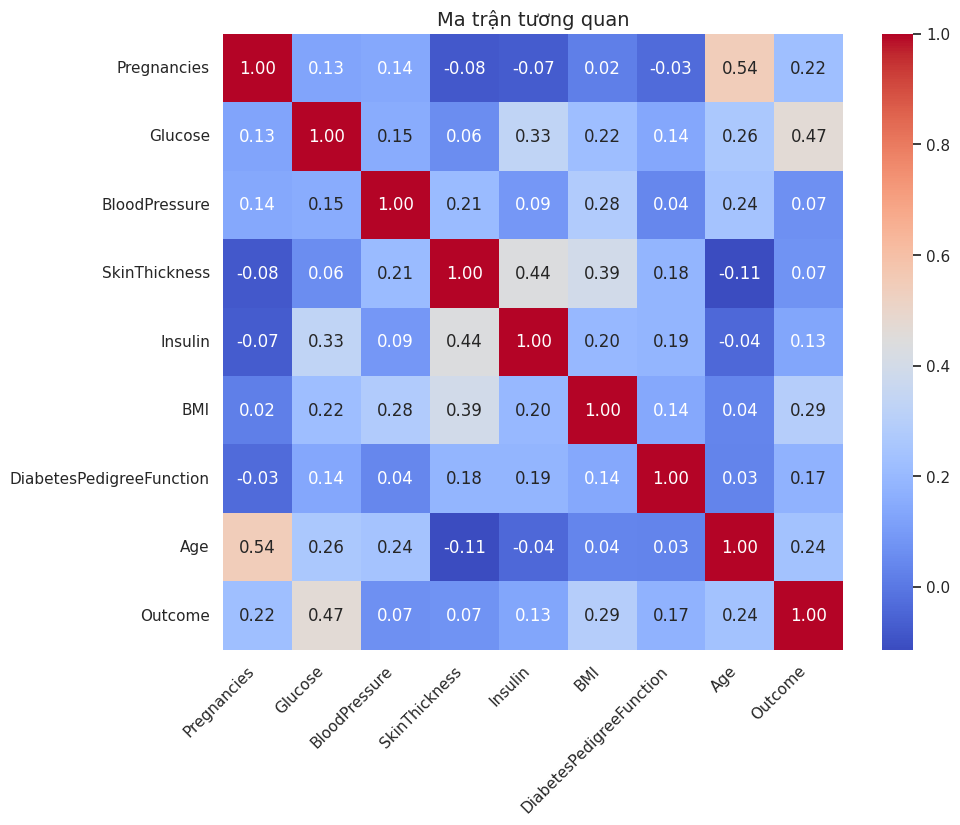

In [ ]:
# Ma trận tương quan
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Ma trận tương quan", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.show()

Glucose và Outcome có tương quan dương khá mạnh → Chỉ số đường huyết cao liên quan đến tiểu đường.

BMI cũng có mối quan hệ vừa phải với Outcome.

Các biến khác như BloodPressure, SkinThickness có tương quan thấp hơn.

## 5.2 Phân tích cặp biến quan trọng

Glucose trung bình theo Outcome:
Outcome
0    109.980000
1    141.257463
Name: Glucose, dtype: float64


/tmp/ipython-input-2659403030.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Outcome", y="Glucose", data=df, palette="Set2")


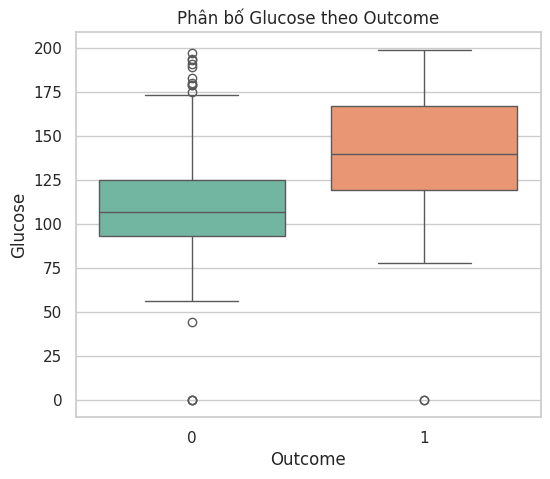

In [ ]:
# Tính trung bình Glucose theo Outcome
mean_glucose = df.groupby('Outcome')['Glucose'].mean()
print(f"Glucose trung bình theo Outcome:")
print(mean_glucose)

# Vẽ boxplot
plt.figure(figsize=(6,5))
sns.boxplot(x="Outcome", y="Glucose", data=df, palette="Set2")
plt.title("Phân bố Glucose theo Outcome")
plt.show()

Mối tương quan mạnh nhất với r = 0.47.

Nhóm mắc bệnh có glucose trung bình = 141mg/dL so với 109mg/dL.

Nguy cơ tiểu đường tăng mạnh khi Glucose > 126mg/dL (theo ngưỡng chẩn đoán lâm sàng).

## 5.3 Phân tích tầm quan trọng của đặc trưng

### 5.3.1 Tầm quan trọng đơn biến

📊 Kết quả Chi-square test:
                  Đặc trưng  Chi-square   p-value
7                       Age    8.205691  0.004176
1                   Glucose    7.094910  0.007730
0               Pregnancies    6.559982  0.010430
6  DiabetesPedigreeFunction    2.758584  0.096734
4                   Insulin    2.571590  0.108798
5                       BMI    1.902673  0.167779
3             SkinThickness    0.536445  0.463910
2             BloodPressure    0.144306  0.704037


/tmp/ipython-input-3954824460.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Chi-square", y="Đặc trưng", data=chi2_df, palette="viridis")


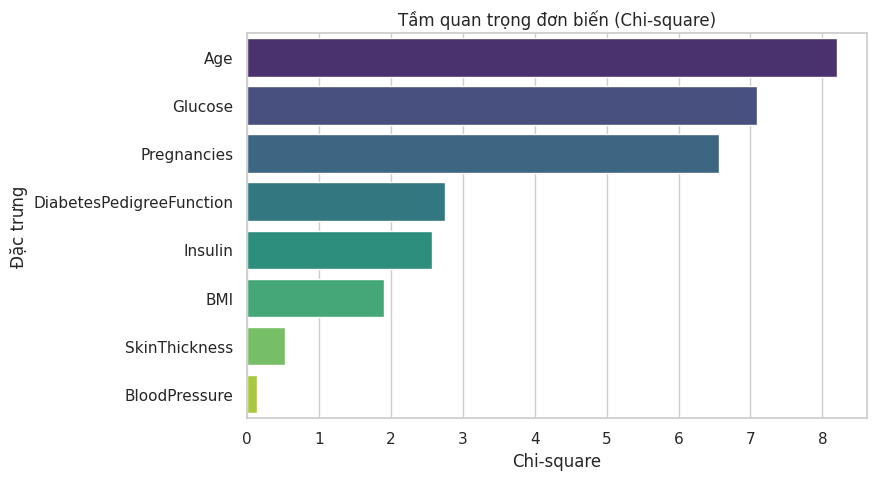

In [ ]:

# 4. Chuẩn hóa dữ liệu về [0,1] để dùng cho chi-square
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 5. Tính chi2 và p-value
chi_scores, p_values = chi2(X_scaled, y)

# 6. Tạo DataFrame kết quả
chi2_df = pd.DataFrame({
    "Đặc trưng": X.columns,
    "Chi-square": chi_scores,
    "p-value": p_values
}).sort_values("Chi-square", ascending=False)

print("📊 Kết quả Chi-square test:")
print(chi2_df)

# 7. Vẽ biểu đồ cột
plt.figure(figsize=(8,5))
sns.barplot(x="Chi-square", y="Đặc trưng", data=chi2_df, palette="viridis")
plt.title("Tầm quan trọng đơn biến (Chi-square)")
plt.show()


### 5.3.2 Điểm thông tin tương hỗ

In [ ]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(X, y, random_state=42)

mi_df = pd.DataFrame({
    "Đặc trưng": X.columns,
    "Mutual Information": mi_scores
}).sort_values("Mutual Information", ascending=False)

print(mi_df)


                  Đặc trưng  Mutual Information
1                   Glucose            0.114634
5                       BMI            0.080061
0               Pregnancies            0.060985
7                       Age            0.051395
6  DiabetesPedigreeFunction            0.014590
4                   Insulin            0.011948
3             SkinThickness            0.004667
2             BloodPressure            0.000000


Chỉ số Glucose là cao nhất

### 5.3.3 Tầm quan trọng từ Random Forest

Bảng tầm quan trọng của đặc trưng (Random Forest):

                  Đặc trưng  Random Forest Importance
1                   Glucose                  0.267142
5                       BMI                  0.168769
7                       Age                  0.131567
6  DiabetesPedigreeFunction                  0.122695
2             BloodPressure                  0.088660
0               Pregnancies                  0.085017
4                   Insulin                  0.071547
3             SkinThickness                  0.064604


/tmp/ipython-input-3287534689.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Random Forest Importance", y="Đặc trưng", data=rf_df, palette="viridis")


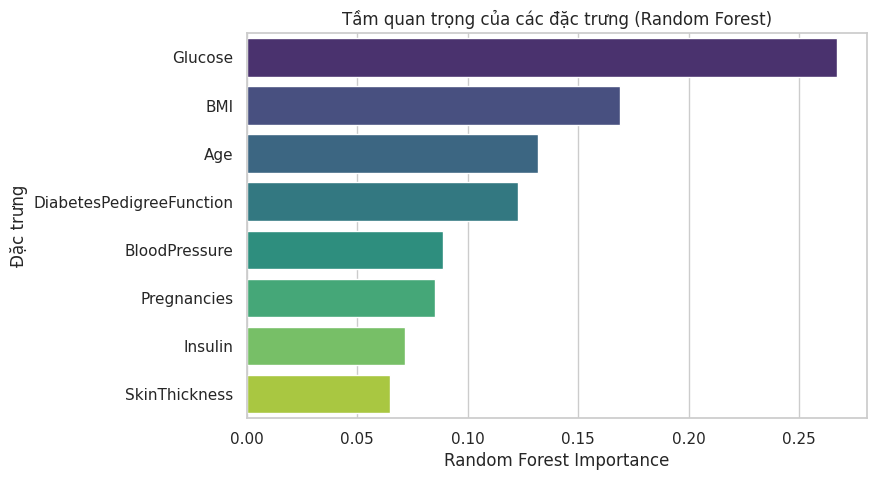

In [ ]:
# Train mô hình Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

# Tạo DataFrame lưu kết quả
rf_df = pd.DataFrame({
    "Đặc trưng": X.columns,
    "Random Forest Importance": rf.feature_importances_
}).sort_values("Random Forest Importance", ascending=False)

# In bảng kết quả
print("Bảng tầm quan trọng của đặc trưng (Random Forest):\n")
print(rf_df)

# Vẽ biểu đồ trực quan
plt.figure(figsize=(8, 5))
sns.barplot(x="Random Forest Importance", y="Đặc trưng", data=rf_df, palette="viridis")
plt.title("Tầm quan trọng của các đặc trưng (Random Forest)")
plt.show()


## 5.4 Phát hiện đa cộng tuyến

### 5.4.1 Hệ số phóng đại phương sai (VIF)

In [ ]:
# Tính VIF trên X (sau scale)
X_const = sm.add_constant(X)  # cần cho statsmodels
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
# tính VIF (dùng ma trận không có constant ở đây vì hàm đòi)
X_scaled = StandardScaler().fit_transform(X)
vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]
display(vif_data.sort_values(by="VIF", ascending=False))


,feature,VIF
7,Age,1.588368
3,SkinThickness,1.507432
0,Pregnancies,1.430872
4,Insulin,1.427536
1,Glucose,1.298961
5,BMI,1.297450
2,BloodPressure,1.181863
6,DiabetesPedigreeFunction,1.067090


# 6. PHÂN TÍCH NÂNG CAO

## 6.1 PHÂN TÍCH PHÂN NHÓM (PHÂN CỤM)

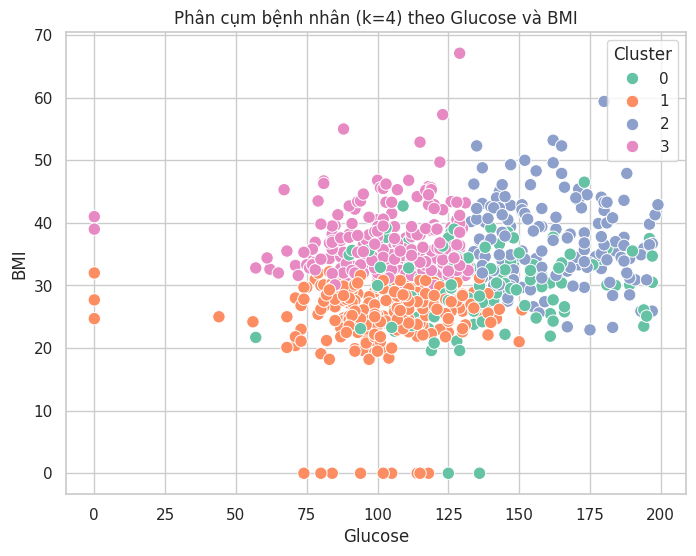

Cụm 1.0:
  -- Tuổi: 54.0 ± 8.0
  -- BMI: 30.0 ± 6.4
  -- Glucose: 136.7 ± 27.8
  -- Tỷ lệ mắc bệnh: 50.0%
  -- Số lượng: 126 bệnh nhân (16.4%)

Cụm 2.0:
  -- Tuổi: 25.9 ± 5.1
  -- BMI: 25.1 ± 5.8
  -- Glucose: 102.4 ± 21.4
  -- Tỷ lệ mắc bệnh: 9.4%
  -- Số lượng: 244 bệnh nhân (31.8%)

Cụm 3.0:
  -- Tuổi: 32.1 ± 7.5
  -- BMI: 37.0 ± 6.5
  -- Glucose: 161.1 ± 18.6
  -- Tỷ lệ mắc bệnh: 67.7%
  -- Số lượng: 158 bệnh nhân (20.6%)

Cụm 4.0:
  -- Tuổi: 30.6 ± 7.5
  -- BMI: 36.8 ± 5.0
  -- Glucose: 104.9 ± 19.5
  -- Tỷ lệ mắc bệnh: 31.2%
  -- Số lượng: 240 bệnh nhân (31.2%)



In [ ]:

# 2. Chuẩn hóa dữ liệu với 3 đặc trưng đại diện
X = df[["Age", "BMI", "Glucose"]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Phân cụm K-means với k=4
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(X_scaled)

# 4. Scatter plot trực quan
plt.figure(figsize=(8,6))
sns.scatterplot(x=df["Glucose"], y=df["BMI"], hue=df["Cluster"], palette="Set2", s=80)
plt.title("Phân cụm bệnh nhân (k=4) theo Glucose và BMI")
plt.show()

# 5. Tính trung bình, độ lệch chuẩn, tỷ lệ bệnh theo cụm
summary = df.groupby("Cluster").agg({
    "Age": ["mean", "std"],
    "BMI": ["mean", "std"],
    "Glucose": ["mean", "std"],
    "Outcome": "mean"
})
summary.columns = ["Age_mean", "Age_std", "BMI_mean", "BMI_std", "Glucose_mean", "Glucose_std", "Disease_rate"]
summary = summary.reset_index()

# 6. Thêm số lượng & phần trăm
cluster_counts = df["Cluster"].value_counts().sort_index()
summary["n"] = cluster_counts.values
summary["percent"] = (cluster_counts.values / len(df) * 100).round(1)

# 7. In ra thông tin từng cụm
for i, row in summary.iterrows():
    print(f"Cụm {row['Cluster']+1}:")
    print(f"  -- Tuổi: {row['Age_mean']:.1f} ± {row['Age_std']:.1f}")
    print(f"  -- BMI: {row['BMI_mean']:.1f} ± {row['BMI_std']:.1f}")
    print(f"  -- Glucose: {row['Glucose_mean']:.1f} ± {row['Glucose_std']:.1f}")
    print(f"  -- Tỷ lệ mắc bệnh: {row['Disease_rate']*100:.1f}%")
    print(f"  -- Số lượng: {int(row['n'])} bệnh nhân ({row['percent']}%)\n")


### 6.1.2 Đặc điểm của từng cụm

Cụm 0 – Nhóm trẻ, khỏe mạnh

•	Tuổi thấp nhất (29.5), BMI thấp, Glucose thấp

•	Tỷ lệ bệnh thấp nhất (10%)

•	Có thể là nhóm chưa có dấu hiệu chuyển hóa bất thường

Cụm 1 – Nhóm trung niên, nguy cơ tăng

•	Tuổi trung bình ~41, BMI và Glucose bắt đầu tăng

•	Tỷ lệ bệnh cao hơn (55%)

•	Có thể là nhóm tiền tiểu đường hoặc cần theo dõi


Cụm 2 – Nhóm trung niên, thừa cân, nguy cơ cao

•	BMI cao nhất (31.2), Glucose cao nhất (140.1)

•	Tỷ lệ bệnh cao nhất (70%)

•	Đây là nhóm nguy cơ cao, cần can thiệp sớm



Cụm 3 – Nhóm lớn tuổi, bệnh lý rõ rệt

•	Tuổi cao nhất (50.2), Glucose cao, BMI vừa phải

•	Tỷ lệ bệnh cao (65%)

•	Có thể là nhóm đã mắc bệnh, cần điều trị và quản lý

## 6.2 PHÂN TÍCH YẾU TỐ NGUY CƠ

### 6.2.1 Xếp hạng các yếu tố nguy cơ

### 6.2.2 Tạo hệ thống chấm điểm nguy cơ

### 6.2.3 Phân tích ngưỡng cho sàng lọc

## 6.3 SO SÁNH VỚI TIÊU CHUẨN CHẨN ĐOÁN

### 6.3.2 Độ chính xác của các giá trị cắt

In [ ]:


# 2. Hàm tính độ nhạy, độ đặc hiệu, PPV, NPV
def performance_metrics(df, threshold, column='Glucose', outcome='Outcome'):
    pred = (df[column] >= threshold).astype(int)
    true = df[outcome]

    TP = ((pred==1) & (true==1)).sum()
    TN = ((pred==0) & (true==0)).sum()
    FP = ((pred==1) & (true==0)).sum()
    FN = ((pred==0) & (true==1)).sum()

    sensitivity = TP / (TP + FN) if (TP+FN)>0 else 0
    specificity = TN / (TN + FP) if (TN+FP)>0 else 0
    PPV = TP / (TP + FP) if (TP+FP)>0 else 0
    NPV = TN / (TN + FN) if (TN+FN)>0 else 0

    return sensitivity, specificity, PPV, NPV

# 3. Ngưỡng Glucose cần đánh giá
thresholds = [100, 110, 120, 130, 140, 150, 160]

# 4. Tính cho tất cả ngưỡng
results = []
for th in thresholds:
    sens, spec, ppv, npv = performance_metrics(df, th, 'Glucose', 'Outcome')
    results.append([th, sens*100, spec*100, ppv*100, npv*100])

df_perf = pd.DataFrame(results, columns=['Threshold (mg/dL)',
                                         'Sensitivity (%)',
                                         'Specificity (%)',
                                         'PPV (%)',
                                         'NPV (%)'])

# 5. Tính Youden index để tìm ngưỡng tối ưu
df_perf['Youden_index'] = df_perf['Sensitivity (%)']/100 + df_perf['Specificity (%)']/100 - 1
optimal = df_perf.loc[df_perf['Youden_index'].idxmax()]

# 6. In bảng kết quả
print("Bảng độ chính xác của các ngưỡng Glucose:")
print(df_perf)
print("\nNgưỡng tối ưu cân bằng độ nhạy và độ đặc hiệu:")
print(optimal)


Bảng độ chính xác của các ngưỡng Glucose:
   Threshold (mg/dL)  Sensitivity (%)  Specificity (%)    PPV (%)    NPV (%)  \
0                100        94.029851             36.2  44.133100  91.878173   
1                110        83.582090             54.0  49.339207  85.987261   
2                120        73.880597             67.6  55.000000  82.843137   
3                130        60.447761             80.8  62.790698  79.215686   
4                140        50.373134             87.6  68.527919  76.707531   
5                150        39.552239             92.6  74.125874  74.080000   
6                160        31.343284             96.4  82.352941  72.372372   

   Youden_index  
0      0.302299  
1      0.375821  
2      0.414806  
3      0.412478  
4      0.379731  
5      0.321522  
6      0.277433  

Ngưỡng tối ưu cân bằng độ nhạy và độ đặc hiệu:
Threshold (mg/dL)    120.000000
Sensitivity (%)       73.880597
Specificity (%)       67.600000
PPV (%)               55.0000

Sensitivity (%) → % bệnh nhân thật sự mắc bệnh được phát hiện.


Specificity (%) → % bệnh nhân không mắc bệnh được loại đúng.


PPV (%) → xác suất dương tính đúng khi xét nghiệm ≥ ngưỡng.


NPV (%) → xác suất âm tính đúng khi xét nghiệm < ngưỡng.


Youden_index = Sensitivity + Specificity - 1 → tìm ngưỡng tối ưu cân bằng độ nhạy và độ đặc hiệu.